<h2><center>THE CHINESE UNIVERSITY OF HONG KONG<br /> 
    Department of Mathematics<br />
 MATH4280<br />
    Innovation and Design in Big Data Analytics</center></h2>

# Tutorial 9<a id='top'></a>

- <a href='#section5'>9.5 Develop Convolutional Neural Network Models</a>
- <a href='#section6'>9.6 Kernel method for SVM</a>
- <a href='#section7'>9.7 How to Visualize a Deep Learning Model</a>
- <a href='#section7'>9.8 How to Get Better Model Performance</a>


## 9.5 Develop Convolutional Neural Network Models<a id='section5'></a>

Convolutional Neural Networks, or CNNs for short, are a type of network designed for image input.

They are comprised of models with convolutional layers that extract features (called feature maps) and pooling layers that distill features down to the most salient elements.

CNNs are most well-suited to image classification tasks, although they can be used on a wide array of tasks that take images as input.

A popular image classification task is the MNIST handwritten digit classification. It involves tens of thousands of handwritten digits that must be classified as a number between 0 and 9.

The tf.keras API provides a convenience function to download and load this dataset directly.

The example below loads the dataset and plots the first few images.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


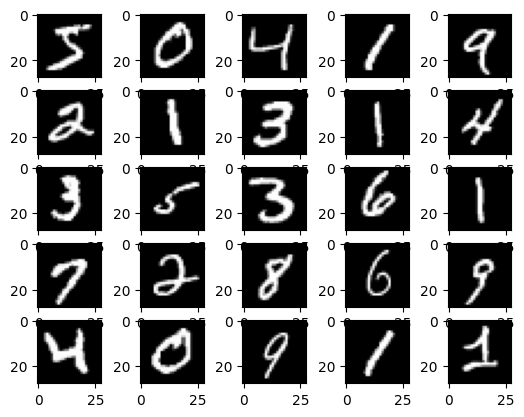

In [1]:
# example of loading and plotting the mnist dataset
from tensorflow.keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
# load dataset
(trainX, trainy), (testX, testy) = load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(25):
	# define subplot
	plt.subplot(5, 5, i+1)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

Running the example loads the MNIST dataset, then summarizes the default train and test datasets.

A plot is then created showing a grid of examples of handwritten images in the training dataset

We can train a CNN model to classify the images in the MNIST dataset.

Note that the images are arrays of grayscale pixel data; therefore, we must add a channel dimension to the data before we can use the images as input to the model. The reason is that CNN models expect images in a channels-last format, that is each example to the network has the dimensions [rows, columns, channels], where channels represent the color channels of the image data.

It is also a good idea to scale the pixel values from the default range of 0-255 to 0-1 when training a CNN. 

The complete example of fitting and evaluating a CNN model on the MNIST dataset is listed below.

In [2]:
# example of a cnn for image classification
from numpy import asarray
from numpy import unique
from numpy import argmax
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

""" 
Data preprocessing:


"""

# load dataset
(x_train, y_train), (x_test, y_test) = load_data()

# reshape data to have a single channel
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)) 
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
# where shape[0] is the number of images,
# shape[1] and shape[2] are the dimensions of the image


# determine the shape of the input images
in_shape = x_train.shape[1:] # obtain (28,28) 

# determine the number of classes
n_classes = len(unique(y_train)) # where `y_train` is the labels
print(in_shape, n_classes)

# try to 
import numpy as np
# optional step: 
# Find maximum and minimum pixel values in the dataset
max_pixel_value = np.max(x_train)
min_pixel_value = np.min(x_train)

# normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# define model


model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))
# define loss and optimizer
from tensorflow.keras.optimizers import Adam
# Define optimizer with customizable parameters
custom_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=custom_adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=0)
# evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)
# make a prediction
image = x_train[0]
yhat = model.predict(asarray([image]))
print('Predicted: class=%d' % argmax(yhat))

(28, 28, 1) 10
Accuracy: 0.987
1/1 [==============================] - 0s 60ms/step
Predicted: class=5


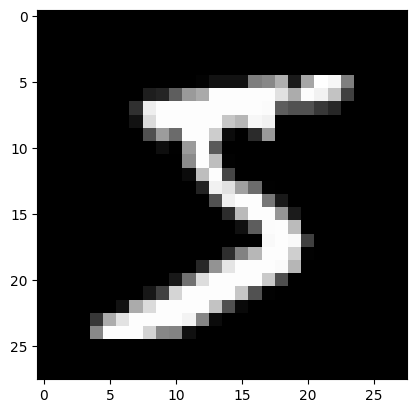

In [3]:
plt.imshow(image.reshape(28,28), cmap=plt.get_cmap('gray'))

First, the shape of each image is reported along with the number of classes; we can see that each image is 28×28 pixels and there are 10 classes as we expected.

In this case, we can see that the model achieved a classification accuracy of about 98 percent on the test dataset. We can then see that the model predicted class 5 for the first image in the training set.

<a href='#top'>jump to the top</a>

## 9.6 Develop Recurrent Neural Network Models <a id='section6'></a>

Recurrent Neural Networks, or RNNs for short, are designed to operate upon sequences of data.

They have proven to be very effective for natural language processing problems where sequences of text are provided as input to the model. RNNs have also seen some modest success for time series forecasting and speech recognition.

The most popular type of RNN is the Long Short-Term Memory network, or LSTM for short. LSTMs can be used in a model to accept a sequence of input data and make a prediction, such as assign a class label or predict a numerical value like the next value or values in the sequence.

We will use the car sales dataset to demonstrate an LSTM RNN for univariate time series forecasting.

This problem involves predicting the number of car sales per month.

We will frame the problem to take a window of the last five months of data to predict the current month’s data.

To achieve this, we will define a new function named split_sequence() that will split the input sequence into windows of data appropriate for fitting a supervised learning model, like an LSTM.

For example, if the sequence was:

```
1, 2, 3, 4, 5, 6, 7, 8, 9, 10
```

Then the samples for training the model will look like:

```
Input 				Output
1, 2, 3, 4, 5 		6
2, 3, 4, 5, 6 		7
3, 4, 5, 6, 7 		8
```

We will use the last 12 months of data as the test dataset.

LSTMs expect each sample in the dataset to have two dimensions; the first is the number of time steps (in this case it is 5), and the second is the number of observations per time step (in this case it is 1).

Because it is a regression type problem, we will use a linear activation function (no activation
function) in the output layer and optimize the mean squared error loss function. We will also evaluate the model using the mean absolute error (MAE) metric.

The complete example of fitting and evaluating an LSTM for a univariate time series forecasting problem is listed below.

In [4]:
# lstm for time series forecasting
from numpy import sqrt
from numpy import asarray
from pandas import read_csv
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return asarray(X), asarray(y)
 
# load the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = read_csv(path, header=0, index_col=0, squeeze=True)
# retrieve the values
values = df.values.astype('float32')
# specify the window size
n_steps = 5
# split into samples
X, y = split_sequence(values, n_steps)
# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# split into train/test
n_test = 12
X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# fit the model
model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=2, validation_data=(X_test, y_test))
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))
# make a prediction
row = asarray([18024.0, 16722.0, 14385.0, 21342.0, 17180.0]).reshape((1, n_steps, 1))
yhat = model.predict(row)
print('Predicted: %.3f' % (yhat))

C:\Users\kinla\AppData\Local\Temp\ipykernel_24600\359538617.py:26: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = read_csv(path, header=0, index_col=0, squeeze=True)


(91, 5, 1) (12, 5, 1) (91,) (12,)
Epoch 1/350
3/3 - 1s - loss: 315344224.0000 - mae: 15184.3652 - val_loss: 40860720.0000 - val_mae: 4930.5024 - 959ms/epoch - 320ms/step
Epoch 2/350
3/3 - 0s - loss: 58919244.0000 - mae: 5950.2803 - val_loss: 151332336.0000 - val_mae: 10609.6387 - 26ms/epoch - 9ms/step
Epoch 3/350
3/3 - 0s - loss: 118212216.0000 - mae: 9500.2246 - val_loss: 97575648.0000 - val_mae: 8245.7920 - 28ms/epoch - 9ms/step
Epoch 4/350
3/3 - 0s - loss: 61300456.0000 - mae: 6440.3633 - val_loss: 71540808.0000 - val_mae: 6746.3931 - 27ms/epoch - 9ms/step
Epoch 5/350
3/3 - 0s - loss: 53289348.0000 - mae: 5573.2988 - val_loss: 130959400.0000 - val_mae: 9323.3682 - 26ms/epoch - 9ms/step
Epoch 6/350
3/3 - 0s - loss: 75477264.0000 - mae: 7131.0898 - val_loss: 87341392.0000 - val_mae: 7133.6792 - 27ms/epoch - 9ms/step
Epoch 7/350
3/3 - 0s - loss: 44870408.0000 - mae: 5230.7617 - val_loss: 44983980.0000 - val_mae: 5484.2319 - 26ms/epoch - 9ms/step
Epoch 8/350
3/3 - 0s - loss: 22282612.00

C:\Users\kinla\AppData\Local\Temp\ipykernel_24600\359538617.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Predicted: %.3f' % (yhat))


First, the shape of the train and test datasets is displayed, confirming that the last 12 examples are used for model evaluation.

In this case, the model achieved an MAE of about 3,000 and predicted the next value in the sequence from the test set as 17,065, where the expected value is 14,577 (pretty close).

<a href='#top'>jump to the top</a>

## 9.7 How to Visualize a Deep Learning Model <a id='section7'></a>

In this section, you will discover how to use some of the slightly more advanced model features, such as reviewing learning curves and saving models for later use.

### 9.7.1 How to Visualize a Deep Learning Model

The architecture of deep learning models can quickly become large and complex.

As such, it is important to have a clear idea of the connections and data flow in your model. This is especially important if you are using the functional API to ensure you have indeed connected the layers of the model in the way you intended.

There are two tools you can use to visualize your model: a text description and a plot.

### Model Text Description
A text description of your model can be displayed by calling the summary() function on your model.

The example below defines a small model with three layers and then summarizes the structure.

In [5]:
# example of summarizing a model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(8,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                90        
                                                                 
 dense_6 (Dense)             (None, 8)                 88        
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 187 (748.00 Byte)
Trainable params: 187 (748.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 9.7.2 How to Plot Model Learning Curves

Learning curves are a plot of neural network model performance over time, such as calculated at the end of each training epoch.

Plots of learning curves provide insight into the learning dynamics of the model, such as whether the model is learning well, whether it is underfitting the training dataset, or whether it is overfitting the training dataset.

You can easily create learning curves for your deep learning models.

First, you must update your call to the fit function to include reference to a validation dataset. This is a portion of the training set not used to fit the model, and is instead used to evaluate the performance of the model during training.

You can split the data manually and specify the validation_data argument, or you can use the validation_split argument and specify a percentage split of the training dataset and let the API perform the split for you. The latter is simpler for now.

The fit function will return a history object that contains a trace of performance metrics recorded at the end of each training epoch. This includes the chosen loss function and each configured metric, such as accuracy, and each loss and metric is calculated for the training and validation datasets.

A learning curve is a plot of the loss on the training dataset and the validation dataset. We can create this plot from the history object using the Matplotlib library.

The example below fits a small neural network on a synthetic binary classification problem. A validation split of 30 percent is used to evaluate the model during training and the cross-entropy loss on the train and validation datasets are then graphed using a line plot.

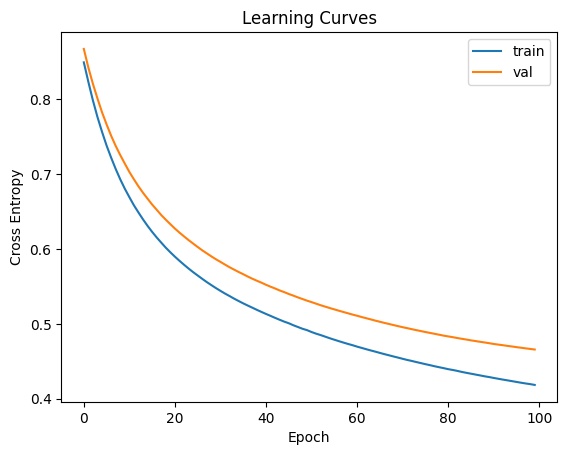

In [6]:
# example of plotting learning curves
from sklearn.datasets import make_classification
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
# create the dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# determine the number of input features
n_features = X.shape[1]
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))
# compile the model
sgd = SGD(learning_rate=0.001, momentum=0.8)
model.compile(optimizer=sgd, loss='binary_crossentropy')
# fit the model
history = model.fit(X, y, epochs=100, batch_size=32, verbose=0, validation_split=0.3)
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

Running the example fits the model on the dataset. At the end of the run, the history object is returned and used as the basis for creating the line plot.

The cross-entropy loss for the training dataset is accessed via the ‘loss‘ key and the loss on the validation dataset is accessed via the ‘val_loss‘ key on the history attribute of the history object.

### 9.7.3 How to Save and Load Your Model

Training and evaluating models is great, but we may want to use a model later without retraining it each time.

This can be achieved by saving the model to file and later loading it and using it to make predictions.

This can be achieved using the save() function on the model to save the model. It can be loaded later using the load_model() function.

The model is saved in H5 format, an efficient array storage format. As such, you must ensure that the h5py library is installed on your workstation. This can be achieved using pip; for example:

In [7]:
# import sys
# !{sys.executable} -m pip install h5py

The example below fits a simple model on a synthetic binary classification problem and then saves the model file.

In [8]:
# example of saving a fit model
from sklearn.datasets import make_classification
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
# create the dataset
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, random_state=1)
# determine the number of input features
n_features = X.shape[1]
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))
# compile the model
sgd = SGD(learning_rate=0.001, momentum=0.8)
model.compile(optimizer=sgd, loss='binary_crossentropy')
# fit the model
model.fit(X, y, epochs=100, batch_size=32, verbose=0, validation_split=0.3)
# save model to file
model.save('model.h5')

c:\Users\kinla\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Running the example fits the model and saves it to file with the name ‘model.h5‘.

We can then load the model and use it to make a prediction, or continue training it, or do whatever we wish with it.

The example below loads the model and uses it to make a prediction.

In [9]:
# example of loading a saved model
from sklearn.datasets import make_classification
from tensorflow.keras.models import load_model
# create the dataset
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, random_state=1)
# load the model from file
model = load_model('model.h5')
# make a prediction
row = [1.91518414, 1.14995454, -1.52847073, 0.79430654]
yhat = model.predict([row])
print('Predicted: %.3f' % yhat[0])

1/1 [==============================] - 0s 51ms/step
Predicted: 0.868


C:\Users\kinla\AppData\Local\Temp\ipykernel_24600\2288827104.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Predicted: %.3f' % yhat[0])


<a href='#top'>jump to the top</a>

## 9.8 How to Get Better Model Performance <a id='section8'></a>

In this section, you will discover some of the techniques that you can use to improve the performance of your deep learning models.

A big part of improving deep learning performance involves avoiding overfitting by slowing down the learning process or stopping the learning process at the right time.

### 9.8.1 How to Reduce Overfitting With Dropout
Dropout is a clever regularization method that reduces overfitting of the training dataset and makes the model more robust.

This is achieved during training, where some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look like – and be treated like – a layer with a different number of nodes and connectivity to the prior layer.

Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.

You can add dropout to your models as a new layer prior to the layer that you want to have input connections dropped-out.

This involves adding a layer called Dropout() that takes an argument that specifies the probability that each output from the previous to drop. E.g. 0.4 means 40 percent of inputs will be dropped each update to the model.

You can add Dropout layers in MLP, CNN, and RNN models, although there are also specialized versions of dropout for use with CNN and RNN models that you might also want to explore.

The example below fits a small neural network model on a synthetic binary classification problem.

A dropout layer with 50 percent dropout is inserted between the first hidden layer and the output layer.

In [10]:
# example of using dropout
from sklearn.datasets import make_classification
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot
# create the dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# determine the number of input features
n_features = X.shape[1]
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')
# fit the model
model.fit(X, y, epochs=100, batch_size=32, verbose=0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 9.8.2 How to Accelerate Training With Batch Normalization

The scale and distribution of inputs to a layer can greatly impact how easy or quickly that layer can be trained.

This is generally why it is a good idea to scale input data prior to modeling it with a neural network model.

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

You can use batch normalization in your network by adding a batch normalization layer prior to the layer that you wish to have standardized inputs. You can use batch normalization with MLP, CNN, and RNN models.

This can be achieved by adding the BatchNormalization layer directly.

The example below defines a small MLP network for a binary classification prediction problem with a batch normalization layer between the first hidden layer and the output layer.

In [11]:
# example of using batch normalization
from sklearn.datasets import make_classification
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from matplotlib import pyplot
# create the dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# determine the number of input features
n_features = X.shape[1]
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')
# fit the model
model.fit(X, y, epochs=100, batch_size=32, verbose=0)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 10)                210       
                                                                 
 batch_normalization (Batch  (None, 10)                40        
 Normalization)                                                  
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 261 (1.02 KB)
Trainable params: 241 (964.00 Byte)
Non-trainable params: 20 (80.00 Byte)
_________________________________________________________________


### 9.8.3 How to Halt Training at the Right Time With Early Stopping

Neural networks are challenging to train.

Too little training and the model is underfit; too much training and the model overfits the training dataset. Both cases result in a model that is less effective than it could be.

One approach to solving this problem is to use early stopping. This involves monitoring the loss on the training dataset and a validation dataset (a subset of the training set not used to fit the model). As soon as loss for the validation set starts to show signs of overfitting, the training process can be stopped.

Early stopping can be used with your model by first ensuring that you have a validation dataset. You can define the validation dataset manually via the validation_data argument to the fit() function, or you can use the validation_split and specify the amount of the training dataset to hold back for validation.

You can then define an EarlyStopping and instruct it on which performance measure to monitor, such as ‘val_loss‘ for loss on the validation dataset, and the number of epochs to observed overfitting before taking action, e.g. 5.

This configured EarlyStopping callback can then be provided to the fit() function via the “callbacks” argument that takes a list of callbacks.

This allows you to set the number of epochs to a large number and be confident that training will end as soon as the model starts overfitting. You might also like to create a learning curve to discover more insights into the learning dynamics of the run and when training was halted.

The example below demonstrates a small neural network on a synthetic binary classification problem that uses early stopping to halt training as soon as the model starts overfitting (after about 50 epochs).

In [12]:
# example of using early stopping
from sklearn.datasets import make_classification
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
# create the dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# determine the number of input features
n_features = X.shape[1]
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')
# configure early stopping
es = EarlyStopping(monitor='val_loss', patience=5)
# fit the model
history = model.fit(X, y, epochs=200, batch_size=32, verbose=0, validation_split=0.3, callbacks=[es])

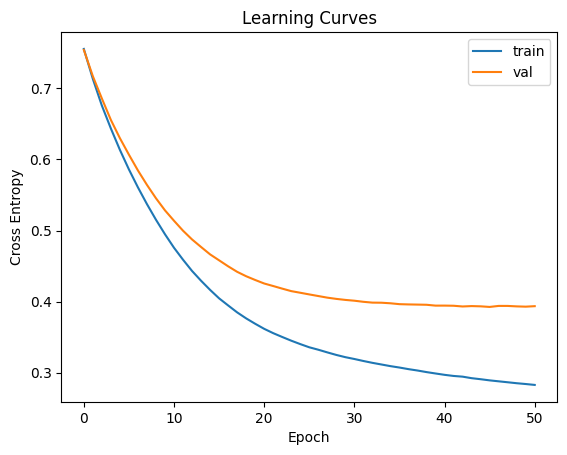

In [13]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

<a href='#top'>jump to the top</a>